In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'
#os.listdir(DATA_PATH)

In [3]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [4]:
# See sdm/R/models/logisticModEDA.R.ipynb for details
#def transform(field, field_name, transform_map):
#    field_min = field.min()
#    field = (field + np.abs(field_min) + 1) ** transform_map[field_name]
#    return field

In [5]:
'''
def transform_data_set(dataframe):
    data = dataframe.copy()
    transform_map = {
        'meanTemp_Annual': 0.4897778,
        'meanTemp_AprAug': 0.3060202,
        'meanTemp_Aug': 0.137697,
        'meanMinTemp_DecFeb': 0.9713939,
        'meanMinTemp_Oct': -0.1194343,
        'meanMinTemp_Jan': 1.064485,
        'meanMinTemp_Mar': 1.355394,
        'meanMaxTemp_Aug': 0.5649293,
        'precip_meanAnnual': 0.05793939,
        'precip_JunAug': 0.6671515,
        'precipPrevious_JunAug': 0.6300606,
        'precip_OctSep': 0.004686869,
        'precipPrevious_OctSep': 0.06690909,
        'precip_growingSeason': 0.4829899,
        'varPrecip_growingSeason': 0.349899,
        'elev_etopo1': 0.4753939}
    for field in transform_map:
        data[field] = transform(data[field], field, transform_map)
    return data
'''

"\ndef transform_data_set(dataframe):\n    data = dataframe.copy()\n    transform_map = {\n        'meanTemp_Annual': 0.4897778,\n        'meanTemp_AprAug': 0.3060202,\n        'meanTemp_Aug': 0.137697,\n        'meanMinTemp_DecFeb': 0.9713939,\n        'meanMinTemp_Oct': -0.1194343,\n        'meanMinTemp_Jan': 1.064485,\n        'meanMinTemp_Mar': 1.355394,\n        'meanMaxTemp_Aug': 0.5649293,\n        'precip_meanAnnual': 0.05793939,\n        'precip_JunAug': 0.6671515,\n        'precipPrevious_JunAug': 0.6300606,\n        'precip_OctSep': 0.004686869,\n        'precipPrevious_OctSep': 0.06690909,\n        'precip_growingSeason': 0.4829899,\n        'varPrecip_growingSeason': 0.349899,\n        'elev_etopo1': 0.4753939}\n    for field in transform_map:\n        data[field] = transform(data[field], field, transform_map)\n    return data\n"

In [4]:
def make_squared(dataframe, fields):
    df = dataframe.copy()
    for field in fields:
        df['%s_sq' % field] = df[field] ** 2
    return df

In [5]:
def make_interactions(dataframe, interactions):
    df = dataframe.copy()
    for interaction in interactions:
        main_effects = interaction.split(':')
        df[interaction] = df[main_effects[0]] * df[main_effects[1]]
    return df

In [6]:
sq_fields = [
    'meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug',
    'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan',
    'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual',
    'precip_JunAug', 'precipPrevious_JunAug', 'precip_OctSep',
    'precipPrevious_OctSep', 'precip_growingSeason',
    'elev_etopo1', 'lat', 'lon']
interactions = [
    'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep',
    'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct',
    'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual',
    'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct',
    'precip_OctSep:elev_etopo1', 'precip_OctSep:elev_etopo1',
    'precip_OctSep:lat', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:precipPrevious_OctSep',
    'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep',
    'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep',
    'precip_OctSep:varPrecip_growingSeason', 'meanTemp_Aug:precip_OctSep']

In [7]:
X_train = make_squared(X_train, sq_fields)
X_valid = make_squared(X_valid, sq_fields)
X_test  = make_squared(X_test, sq_fields)

In [8]:
X_train = make_interactions(X_train, interactions)
X_valid = make_interactions(X_valid, interactions)
X_test  = make_interactions(X_test, interactions)

In [9]:
#list(X_train)

In [10]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.26%
Percent presence in y_valid: 13.92%
Percent presence in y_test: 12.64%


In [11]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [12]:
np.isfinite(X_valid).all()

year                                      True
meanTemp_Annual                           True
meanTemp_AprAug                           True
meanTemp_Aug                              True
meanMinTemp_DecFeb                        True
meanMinTemp_Oct                           True
meanMinTemp_Jan                           True
meanMinTemp_Mar                           True
meanMaxTemp_Aug                           True
precip_meanAnnual                         True
precip_JunAug                             True
vegetation                                True
precipPrevious_JunAug                     True
precip_OctSep                             True
precipPrevious_OctSep                     True
precip_growingSeason                      True
varPrecip_growingSeason                  False
elev_etopo1                               True
lat                                       True
lon                                       True
studyArea                                 True
elev_srtm30  

In [13]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

X_train, y_train = util.drop_nans(
    X_train, y_train, 'precip_OctSep:varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'precip_OctSep:varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'precip_OctSep:varPrecip_growingSeason')

(526849, 59) (526849, 1)
(176146, 59) (176146, 1)
(175416, 59) (175416, 1)
(526849, 59) (526849, 1)
(176146, 59) (176146, 1)
(175416, 59) (175416, 1)


In [14]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [15]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], 
                       axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], 
                       axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  
                      axis=1)

In [16]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'meanTemp_Annual_sq', 'meanTemp_AprAug_sq', 'meanTemp_Aug_sq', 'meanMinTemp_DecFeb_sq', 'meanMinTemp_Oct_sq', 'meanMinTemp_Jan_sq', 'meanMinTemp_Mar_sq', 'meanMaxTemp_Aug_sq', 'precip_meanAnnual_sq', 'precip_JunAug_sq', 'precipPrevious_JunAug_sq', 'precip_OctSep_sq', 'precipPrevious_OctSep_sq', 'precip_growingSeason_sq', 'elev_etopo1_sq', 'lat_sq', 'lon_sq', 'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep', 'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct', 'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason', 'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual', 'precip_OctSep:mean

In [17]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [18]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [19]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
#Cs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
Cs = [0.0001, 0.001, 0.01, 0.1, 1]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001; (l1) Elapsed time: 0.02 minutes
(l2) Elapsed time: 0.06 minutes
Testing C = 0.001; (l1) Elapsed time: 0.12 minutes
(l2) 

KeyboardInterrupt: 

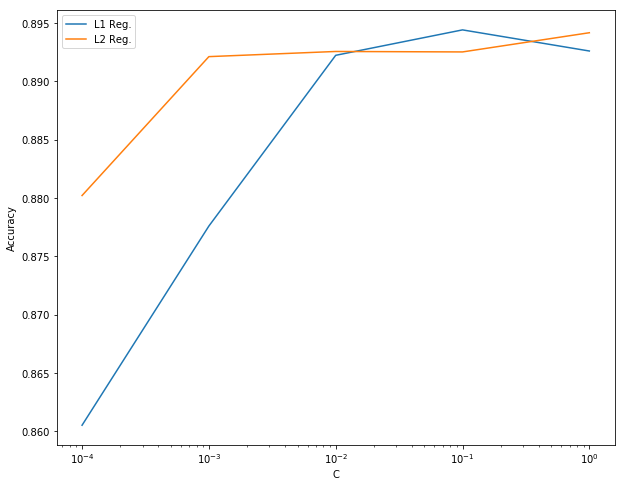

In [23]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [24]:
print(l1_mods)
print(l2_mods)

[0.86051911482520183, 0.87760153509020922, 0.8922427985875353, 0.89442280835216237, 0.89261181065706852]
[0.88021868222951416, 0.89212925641229435, 0.8925720708957342, 0.89253233113439989, 0.89417869267539429]


In [24]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
#Cs = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 
Cs = [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.02; (l1) Elapsed time: 0.73 minutes
(l2) Elapsed time: 0.80 minutes
Testing C = 0.04; (l1) Elapsed time: 3.51 minutes
(l2) Elapsed time: 3.58 minutes
Testing C = 0.06; (l1) Elapsed time: 9.00 minutes
(l2) Elapsed time: 9.08 minutes
Testing C = 0.08; (l1) Elapsed time: 15.24 minutes
(l2) Elapsed time: 15.34 minutes
Testing C = 0.1; (l1) Elapsed time: 22.34 minutes
(l2) Elapsed time: 22.44 minutes
Testing C = 0.2; (l1) Elapsed time: 29.42 minutes
(l2) Elapsed time: 29.53 minutes
Testing C = 0.4; (l1) Elapsed time: 43.77 minutes
(l2) Elapsed time: 43.91 minutes
Testing C = 0.6; (l1) Elapsed time: 60.40 minutes
(l2) Elapsed time: 60.55 minutes
Testing C = 0.8; (l1) Elapsed time: 70.17 minutes
(l2) Elapsed time: 70.33 minutes


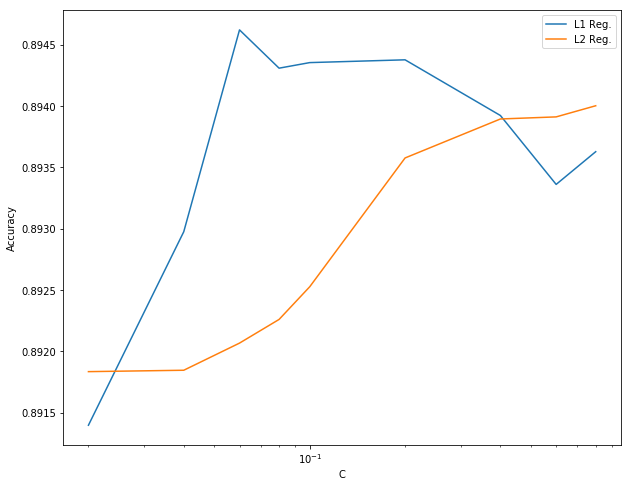

In [25]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [22]:
print(l1_mods)
print(l2_mods)

[0.8913969093819899, 0.89292405163898125, 0.8946442155938823, 0.89432062039444549, 0.89436036015577991, 0.89439442280835213, 0.89392889988986413, 0.89340092877499344, 0.89301488537917406]
[0.88021868222951416, 0.8918226925391437, 0.89184540097419185, 0.89207248532467387, 0.89222009015248716, 0.89253233113439989, 0.89356556492909289, 0.89387212880224365, 0.89388348301976772, 0.89399134808624658]


In [26]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
#Cs = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 
Cs = [0.05, 0.06, 0.07]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1']: #, 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.05; (l1) Elapsed time: 5.27 minutes
Testing C = 0.06; (l1) Elapsed time: 12.55 minutes
Testing C = 0.07; (l1) Elapsed time: 20.32 minutes


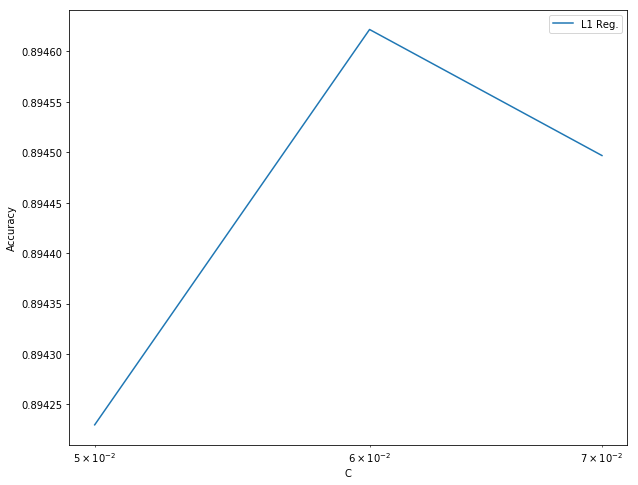

In [28]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
#plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [ ]:
print(l1_mods)

In [29]:
logistic_clf = LogisticRegression(C=0.06, penalty='l1')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.87671022027637158

In [30]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[  9.99968895e-01   3.11050905e-05]
 [  9.99972286e-01   2.77144003e-05]
 [  9.99963205e-01   3.67952035e-05]
 [  9.99950816e-01   4.91843064e-05]
 [  9.99955242e-01   4.47578104e-05]]


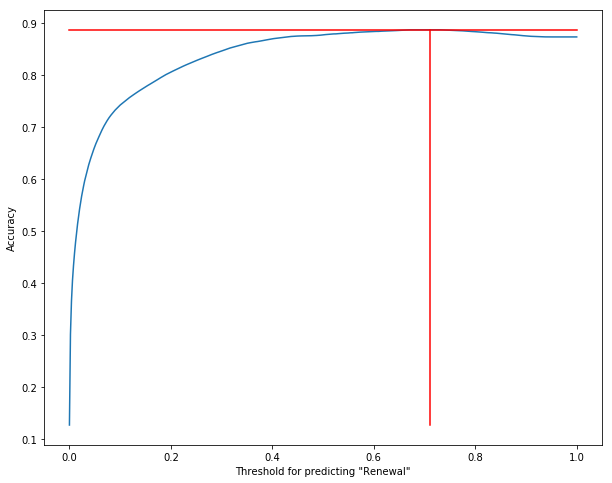

{'threshold': 0.7114228456913827, 'accuracy': 0.88670360742463628}


In [31]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [32]:
preds = logistic_clf.predict(X_test)

In [33]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	13958		8356
        0	13271		139831
Accuracy:  0.876710220276
Precision: 0.512615226413
Recall:    0.625526575244
F1:        0.563470116868


In [34]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.7114228456913827)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	7602		14712
        0	5162		147940
Accuracy:  0.886703607425
Precision: 0.595581322469
Recall:    0.340682979296
F1:        0.433434061235


In [35]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.914399891168


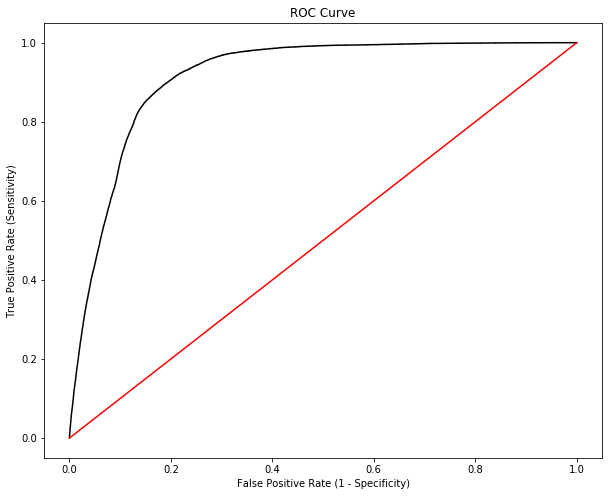

In [36]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [37]:
coefs = pd.DataFrame([[pred, coef] for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
                     columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
17,lat,8.346123
18,lon,-7.712528
40,precip_OctSep:lon,7.703080
35,lon_sq,-7.286693
34,lat_sq,-6.132289
47,precip_OctSep:lat,-3.988279
13,precipPrevious_OctSep,3.690817
20,meanTemp_AprAug_sq,-3.513805
12,precip_OctSep,3.369235
1,meanTemp_AprAug,3.099913


In [38]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix

In [39]:
full_test['preds'] = preds
full_test.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,precip_OctSep:elev_etopo1,precip_OctSep:lat,precip_OctSep:precip_meanAnnual,precip_OctSep:precip_OctSep,meanMaxTemp_Aug:precip_OctSep,meanTemp_AprAug:precip_OctSep,precip_OctSep:varPrecip_growingSeason,meanTemp_Aug:precip_OctSep,beetle,preds
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,6720.300729,3942.380630,930.493385,16702.086497,3508.470629,2441.554720,87.162470,2792.655201,0,0
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,1885.374647,3385.157228,734.347107,12299.783937,3032.901079,2119.301565,87.706257,2418.688598,0,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,15701.586859,3175.790555,676.543063,10812.676193,2973.615041,2053.322479,180.105604,2350.966874,0,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,98718.653594,6033.479765,1962.119381,38981.490270,5676.177043,3724.608934,33.989244,4365.768436,0,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,109969.942702,5961.906526,1937.963301,38018.045803,5813.019043,3768.656495,71.096740,4432.299443,0,0


In [40]:
def pred_plot(actual_matrix, pred_matrix, error_matrix, year):
    plt.subplot(131)
    imshow(np.rot90(actual_matrix));
    plt.title('%d Actual' % year);
    plt.subplot(132)
    imshow(np.rot90(pred_matrix));
    plt.title('%d Predicted' % year);
    plt.subplot(133)
    imshow(np.rot90(error_matrix));
    plt.title('%d Error' % year);

In [41]:
def make_actual_pred_and_error_matrices(data, year, plot=False):
    data_year = data.loc[data.year == year, :]
    actual_matrix = column2matrix(data_year, 'beetle')
    pred_matrix   = column2matrix(data_year, 'preds')
    error_matrix  = pred_matrix - actual_matrix
    
    if plot:
        pred_plot(actual_matrix, pred_matrix, error_matrix, year)
        
    return actual_matrix, pred_matrix, error_matrix

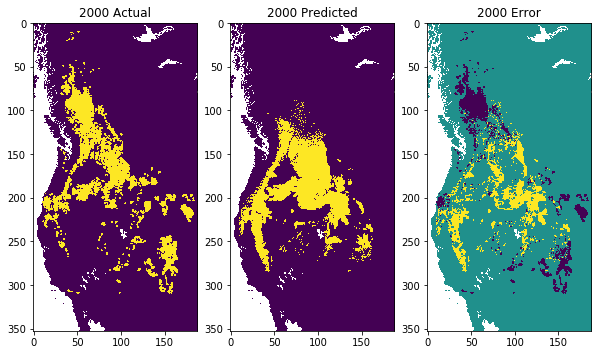

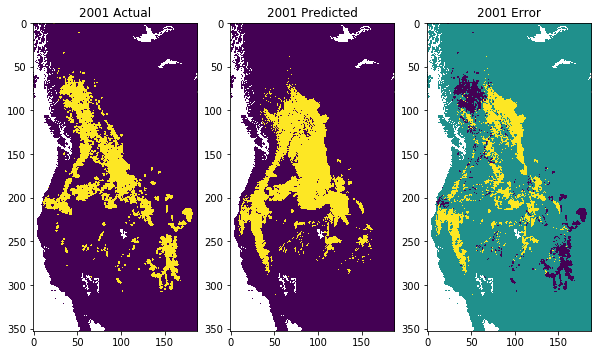

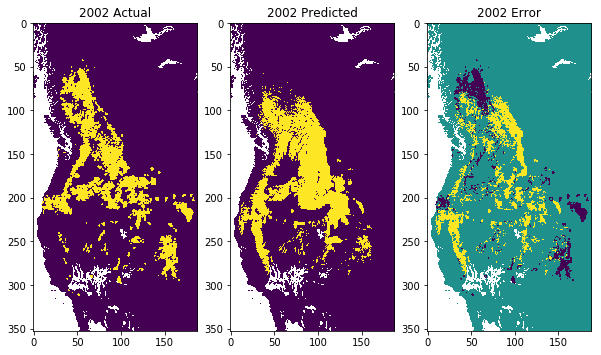

In [42]:
pred_years = [2000, 2001, 2002]
for year in pred_years:
    plt.figure();
    make_actual_pred_and_error_matrices(full_test, year, plot=True)